### **Metropolis-Hastings MCMC: Code & Visual Explanation**

Sampling from a distribution proportional to $\pi(A)=3$ and $\pi(B)=1$.

**1. Problem Setup**

*   **States:** $\{A, B\}$
*   **Unnormalized Target:** $\pi(A) = 3$, $\pi(B) = 1$ (Target: 75% A, 25% B)
*   **Proposal $Q(x'|x)$:** Symmetric; always propose the *other* state.
*   **Acceptance Probability $\alpha(x'|x)$:** $\min(1, \pi(x')/\pi(x))$
    *   $\alpha(B | A) = \min(1, 1/3) = 1/3$
    *   $\alpha(A | B) = \min(1, 3/1) = 1$

**2. Implementation in Python**

In [1]:
import random
import matplotlib.pyplot as plt
from collections import Counter

# --- 1. Define the Target Distribution (Unnormalized) ---
target_pi = {"A": 3.0, "B": 1.0}
states = list(target_pi.keys()) # ["A", "B"]

# --- 2. Define the Proposal Distribution ---
# Given current state, propose the other state
def propose_state(current_state):
    if current_state == "A":
        return "B"
    else: # current_state == "B"
        return "A"
    # Note: For this simple case Q(x'|x) = Q(x|x') = 1 if x' != x, 0 otherwise.
    # It's symmetric.

# --- 3. Define the Acceptance Probability ---
# Uses the simplified Metropolis formula because Q is symmetric
def acceptance_probability(current_state, proposed_state, target_dist):
    pi_current = target_dist[current_state]
    pi_proposed = target_dist[proposed_state]
    
    acceptance_ratio = pi_proposed / pi_current
    
    return min(1.0, acceptance_ratio)

# --- 4. The MCMC Step Function ---
def mcmc_step(current_state, target_dist):
    # a) Propose a new state
    proposed = propose_state(current_state)
    
    # b) Calculate acceptance probability
    alpha = acceptance_probability(current_state, proposed, target_dist)
    
    # c) Decide to accept or reject
    u = random.uniform(0, 1) # Generate random number [0, 1)
    
    if u < alpha:
        # Accept the proposal
        next_state = proposed
    else:
        # Reject the proposal, stay in current state
        next_state = current_state
        
    return next_state

# --- 5. Run the MCMC Simulation ---
def run_mcmc(initial_state, target_dist, num_steps):
    # Check if initial state is valid
    if initial_state not in target_dist:
        raise ValueError("Initial state not in target distribution states")
        
    chain = [initial_state] # Start the chain
    current = initial_state
    
    for _ in range(num_steps):
        current = mcmc_step(current, target_dist)
        chain.append(current) # Add the *result* of the step
        
    return chain

**3. Running the Simulation**

In [2]:
# Simulation Parameters
num_iterations = 5000
start_state = "A" # Can start in A or B

# Run the simulation
mcmc_chain = run_mcmc(start_state, target_pi, num_iterations)

# Display the first few states
print(f"First 20 states: {mcmc_chain[:20]}") 

First 20 states: ['A', 'A', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'B']


**4. Visualization and Analysis**

Now, let's visualize the results.

*   **a) Trace Plot:** Shows the sequence of states visited over time. This helps visualize the chain's movement and convergence.

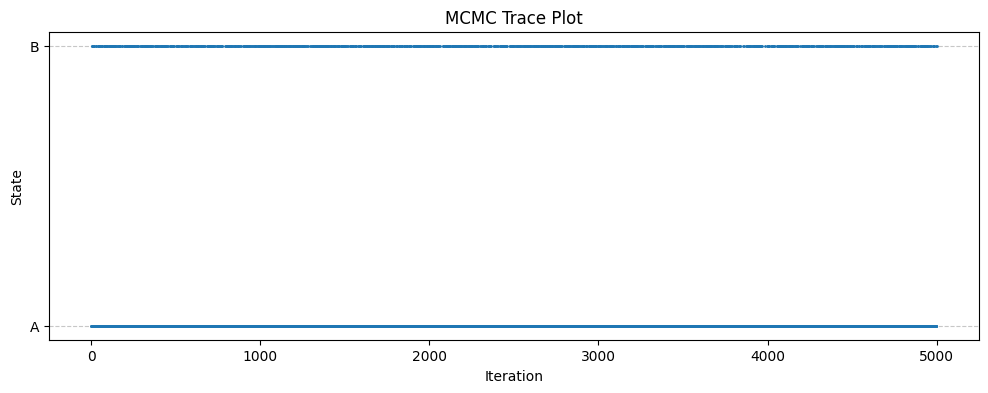

In [3]:
# Map states to numbers for plotting (e.g., A=0, B=1)
state_map = {"A": 0, "B": 1}
numeric_chain = [state_map[s] for s in mcmc_chain]

plt.figure(figsize=(12, 4))
plt.plot(numeric_chain, drawstyle='steps-post', marker='.', markersize=2, linestyle='') # Use steps-post for discrete states
plt.yticks([0, 1], ["A", "B"]) # Label y-axis with state names
plt.xlabel("Iteration")
plt.ylabel("State")
plt.title("MCMC Trace Plot")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

*   **Interpretation:** You'll see the plot jumping between State A (0) and State B (1). Notice how it tends to stay longer in State A, occasionally jumping to B, and almost always immediately jumping back from B to A (because $\alpha(A|B)=1$). If the chain started far from equilibrium (less relevant here with only 2 states), you might see the initial behaviour differ from the later behaviour (indicating burn-in).

*   **b) Histogram of Samples (Post Burn-in):** Shows the frequency of each state in the chain, approximating the target distribution. We should discard the initial "burn-in" phase.

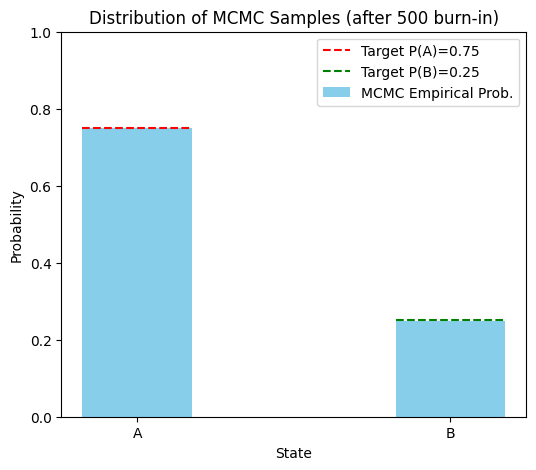


Target Probabilities: P(A)=0.750, P(B)=0.250
Empirical Probabilities (from 4501 samples after burn-in):
  P(A) = 0.751
  P(B) = 0.249


In [4]:
# Define burn-in period (e.g., first 10% of samples)
burn_in = int(num_iterations * 0.1)
samples_after_burn_in = mcmc_chain[burn_in:]

# Count the occurrences of each state
state_counts = Counter(samples_after_burn_in)
total_samples = len(samples_after_burn_in)

# Calculate empirical probabilities
empirical_probs = {state: count / total_samples for state, count in state_counts.items()}

# --- Plotting the Histogram ---
states_list = list(empirical_probs.keys())
emp_probs_list = [empirical_probs.get(s, 0) for s in states] # Ensure order A, B

# Target probabilities for comparison
target_probs_list = [target_pi["A"] / (target_pi["A"] + target_pi["B"]),
                     target_pi["B"] / (target_pi["A"] + target_pi["B"])]


plt.figure(figsize=(6, 5))
bar_width = 0.35
index = range(len(states))

# Bar for empirical probabilities
plt.bar(index, emp_probs_list, bar_width, label='MCMC Empirical Prob.', color='skyblue')

# Add target probabilities as lines or points for comparison
plt.hlines(target_probs_list[0], -bar_width/2, bar_width/2, colors='red', linestyles='dashed', label=f'Target P(A)={target_probs_list[0]:.2f}')
plt.hlines(target_probs_list[1], 1-bar_width/2, 1+bar_width/2, colors='green', linestyles='dashed', label=f'Target P(B)={target_probs_list[1]:.2f}')

plt.xlabel("State")
plt.ylabel("Probability")
plt.title(f"Distribution of MCMC Samples (after {burn_in} burn-in)")
plt.xticks(index, states)
plt.legend()
plt.ylim(0, 1)
plt.show()

print(f"\nTarget Probabilities: P(A)={target_probs_list[0]:.3f}, P(B)={target_probs_list[1]:.3f}")
print(f"Empirical Probabilities (from {total_samples} samples after burn-in):")
for state, prob in empirical_probs.items():
    print(f"  P({state}) = {prob:.3f}")

*   **Interpretation:** The blue bars show the fraction of time the chain spent in State A and State B *after* the burn-in period. The dashed lines show the true target probabilities (0.75 for A, 0.25 for B). You should see that the empirical probabilities (blue bars) are very close to the target probabilities (dashed lines), demonstrating that the MCMC simulation successfully sampled from the desired distribution.

**5. Key Takeaways Illustrated**

*   **Code Implementation:** The core logic (propose, calculate ratio, accept/reject) is straightforward to implement.
*   **Trace Plot:** Visualizes the chain's exploration and potential burn-in phase. Shows individual accept/reject decisions implicitly.
*   **Histogram:** Provides the main result – an empirical approximation of the target distribution derived from the MCMC samples. Compares visually against the known target.
*   **Convergence:** Running for more steps (`num_iterations`) generally leads to the empirical distribution getting closer to the target distribution.
*   **Burn-in:** Discarding initial samples helps remove bias from the starting state.

This example, though simple, captures the essential mechanics of the Metropolis-Hastings algorithm, which scales to much more complex, high-dimensional problems where the target distribution is intractable.